In [1]:
import os
import torch
import librosa
import pandas as pd
from sklearn.metrics import confusion_matrix
import shutil
from jiwer import cer
from datasets import Dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Trainer, TrainingArguments, TrainerCallback, TrainerControl, TrainingArguments, Trainer

from visualizations import vis_accuracy_cer, vis_silence_detection_accuracy, vis_accuracy_cer_one_file, show_confusion_matrix
from create_datasets import create_silence_detection_list, create_dataset, train_test_split_silence_detection, create_dataset_silence_classification, create_approach_2_lists
from utils_wav2wec import *

c:\Users\bagin\PycharmProjects\DL\2024Z_DeepLearning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load model

In [31]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

### Predict single audio

In [4]:
predict_single_audio(model, processor, 'data/train/audio/happy/0ab3b47d_nohash_0.wav')

Transcription for data/train/audio/happy/0ab3b47d_nohash_0.wav: HAPPY


'HAPPY'

# First approach: classification of silence, classification of other classes, relabeling unnecessary classes as unknown

## Datasets
### Create & save datasets

In [5]:
audio_dir = "data/train/audio/" 

#### Datasets without silence

In [32]:
audio_dir = "data/train/audio/" 
dataset_train = create_dataset(audio_dir, processor, 'training_list')
dataset_train.save_to_disk('./datasets/dataset_train')

c:\Users\bagin\PycharmProjects\DL\2024Z_DeepLearning\.venv\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
dataset_valid = create_dataset(audio_dir, processor, 'validation_list')
dataset_valid.save_to_disk('./datasets/dataset_valid')

In [ ]:
dataset_test = create_dataset(audio_dir, processor, 'testing_list')
dataset_test.save_to_disk('./datasets/dataset_test')

#### Silence detection datasets

In [3]:
create_silence_detection_list()
train_test_split_silence_detection()

In [8]:
dataset_train_silence_detection = create_dataset_silence_classification(audio_dir, processor, 'train_silence_detection_list')
dataset_train_silence_detection.save_to_disk('./datasets/dataset_train_silence_detection')

Saving the dataset (1/1 shards): 100%|██████████| 1920/1920 [00:00<00:00, 21606.84 examples/s]


In [9]:
dataset_test_silence_detection = create_dataset_silence_classification(audio_dir, processor, 'test_silence_detection_list')
dataset_test_silence_detection.save_to_disk('./datasets/dataset_test_silence_detection')

Saving the dataset (1/1 shards): 100%|██████████| 480/480 [00:00<00:00, 25263.72 examples/s]


### Load datasets

In [33]:
dataset_train = Dataset.load_from_disk("./datasets/dataset_train")
dataset_valid = Dataset.load_from_disk("./datasets/dataset_valid")
dataset_test = Dataset.load_from_disk("./datasets/dataset_test")

In [3]:
dataset_test_silence_detection = Dataset.load_from_disk("./datasets/dataset_test_silence_detection")
dataset_train_silence_detection = Dataset.load_from_disk("./datasets/dataset_train_silence_detection")

## Silence detection - binary classification model

In [7]:
training_args = TrainingArguments(
    output_dir="./output_dir",
    per_device_train_batch_size=16,
    num_train_epochs=10,
    logging_dir="./logs",
    save_strategy='epoch', 
    evaluation_strategy='epoch',
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    labels = [list(item[0]) for item in labels]
    if all(isinstance(i, list) for i in preds):
        preds = [item for sublist in preds for item in sublist]
    pred_transcriptions = processor.batch_decode(preds)
    true_transcriptions = processor.batch_decode(labels)

    correct_predictions = sum([true == pred for true, pred in zip(true_transcriptions, pred_transcriptions)])
    accuracy = correct_predictions / len(true_transcriptions)

    pred_transcriptions_modification = ['SOUND' if len(pred) > 0 else '' for pred in pred_transcriptions]
    correct_predictions_modification = sum([true == pred for true, pred in zip(true_transcriptions, pred_transcriptions_modification)])
    accuracy_modification = correct_predictions_modification / len(true_transcriptions)
    return {"accuracy": accuracy, 'accuracy_modification': accuracy_modification}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train_silence_detection,
    eval_dataset=dataset_test_silence_detection,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[SaveMetricsCallbackSilence(dataset_test_silence_detection)],
)

trainer.train()
trainer.save_model(f"models/model_silence_detection")

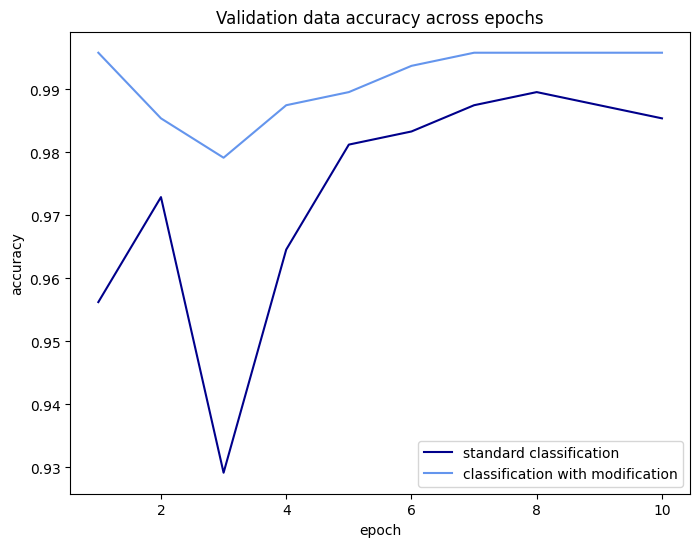

In [6]:
vis_silence_detection_accuracy('data_for_vis/accuracy_silence_detection_.csv')

### Silence detection on the test data 

In [5]:
model_silence_detection = Wav2Vec2ForCTC.from_pretrained("models/model_silence_detection")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
audio_dir = "./data/train/audio/"

with open("./data/train/testing_with_silence_list.txt", "r") as file:
    testing_audio_files = [line.strip() for line in file]
    
correct_silence_predictions = 0
total_files = len(testing_audio_files)

with open('./data/train/testing_non_silent_files.txt', 'w') as f:
    for audio_file in testing_audio_files:
        audio, rate = librosa.load(os.path.join(audio_dir, audio_file), sr=16000)
        inputs = processor(audio, return_tensors="pt", padding=True, sampling_rate=16000)
        with torch.no_grad():
            logits = model_silence_detection(inputs.input_values).logits

        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.decode(predicted_ids[0])
        if len(transcription)>0:
            predicted_label = 'sound'
            f.write(f'{audio_file}\n')
        else:
            predicted_label = 'silence'
        
        true_label = audio_file.split('/')[0]
        if true_label == 'silence':
            if predicted_label == 'silence':
                correct_silence_predictions += 1
        else:
            if predicted_label != 'silence':
                correct_silence_predictions += 1

accuracy = correct_silence_predictions / total_files
print(f'Accuracy of silence detection: {accuracy * 100}%')

Accuracy of silence detection: 99.8756390769656%


## Speech classification

### Fine-tune & adjust speech classification model

In [6]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.freeze_feature_extractor()
model.to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [5]:
shutil.rmtree('./logs', ignore_errors=True)

In [6]:
def train_adjusted_model(lr):
    training_args = TrainingArguments(
        output_dir="./output_dir",
        per_device_train_batch_size=16,
        num_train_epochs=20,
        logging_dir="./logs",
        save_strategy='epoch', 
        evaluation_strategy='epoch',
        learning_rate=lr
    )

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)

        labels = [list(item[0]) for item in labels]
        if all(isinstance(i, list) for i in preds):
            preds = [item for sublist in preds for item in sublist]
        pred_transcriptions = processor.batch_decode(preds)
        true_transcriptions = processor.batch_decode(labels)
        wer_score = wer(true_transcriptions, pred_transcriptions)
        cer_score = cer(true_transcriptions, pred_transcriptions)

        correct_predictions = sum([true == pred for true, pred in zip(true_transcriptions, pred_transcriptions)])
        total_predictions = len(true_transcriptions)
        accuracy = correct_predictions / total_predictions

        available_labels = get_available_labels('data/train/audio/')
        cer_score_closest, accuracy_closest = compute_metrics_with_closest_label(available_labels, pred_transcriptions, true_transcriptions)

        return {"wer": wer_score, "accuracy": accuracy, "cer": cer_score, "accuracy_closest": accuracy_closest, "cer_closest": cer_score_closest}


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset_train,
        eval_dataset=dataset_valid,
        tokenizer=processor,
        compute_metrics=compute_metrics,
        callbacks=[SaveMetricsCallback(dataset_valid, lr)],
    )

    trainer.train()
    trainer.save_model(f"models/model_lr_{lr}")

In [7]:
# lrs = [0.0001, 0.000005, 0.00001, 0.000005]
lrs = [0.0001, 0.000005]
for lr in lrs:
    train_adjusted_model(lr)

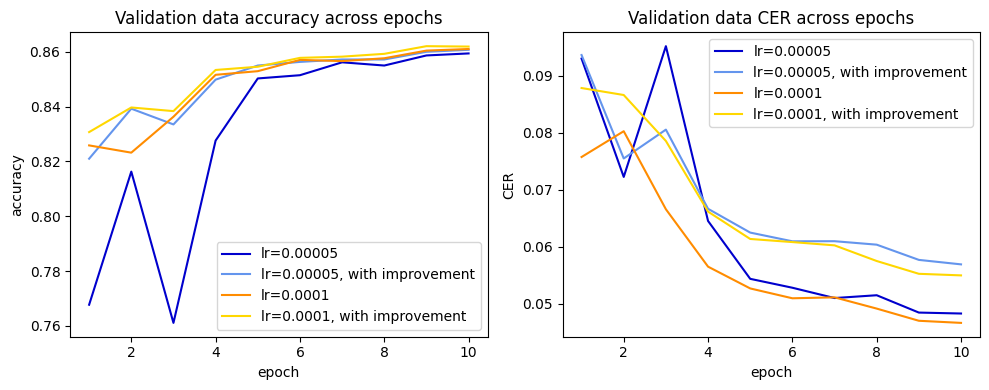

In [3]:
vis_accuracy_cer("data_for_vis/validation_metrics_5e-05.csv", "data_for_vis/validation_metrics_0.0001.csv")

### Prediction on test data 

In [7]:
model_speech_classification = Wav2Vec2ForCTC.from_pretrained("models/model_lr_0.0001")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
audio_dir = "./data/train/audio/"
available_labels = get_available_labels("./data/train/audio/")

with open("./data/train/approach_1_lists/testing_non_silent_files.txt", "r") as file:
    testing_speech_files = [line.strip() for line in file]
    
correct_silence_predictions = 0
total_cer = 0
total_cer_org = 0
correct_speech_predictions = 0
correct_speech_predictions_org = 0

true_labels = []
predicted_labels = []

with open('./data/train/results/testing_classification.txt', 'w') as f:
    for audio_file in testing_speech_files:
        audio, rate = librosa.load(os.path.join(audio_dir, audio_file), sr=16000)
        inputs = processor(audio, return_tensors="pt", padding=True, sampling_rate=16000)
        with torch.no_grad():
            logits = model_speech_classification(inputs.input_values).logits

        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.decode(predicted_ids[0])

        true_label = audio_file.split('/')[0]
        closest_label = min(available_labels, key=lambda l: Levenshtein.distance(l, transcription)).lower()
        
        true_labels.append(true_label)
        predicted_labels.append(closest_label)
        
        if closest_label == true_label:
            correct_speech_predictions += 1
        total_cer += cer(true_label, closest_label)
        if transcription.lower() == true_label:
            correct_speech_predictions_org += 1
        total_cer_org += cer(true_label, transcription.lower())
        f.write(f'{audio_file},{closest_label}\n')

available_labels_lower = [label.lower() for label in available_labels]
conf_mat = confusion_matrix(true_labels, predicted_labels, labels=available_labels_lower)
df = pd.DataFrame(conf_mat, index=available_labels_lower, columns=available_labels_lower)
df.to_csv('./data/train/results/confusion_matrix_a1.csv')

accuracy_speech = correct_speech_predictions / len(testing_speech_files)
my_cer = total_cer / len(testing_speech_files)
print(f'Accuracy of speech classification: {accuracy_speech * 100}%')
print(f'CER of speech classification: {my_cer * 100}%')
print(f'Accuracy of speech classification org: {correct_speech_predictions_org / len(testing_speech_files) * 100}%')
print(f'CER of speech classification org : {total_cer_org / len(testing_speech_files) * 100}%')

Accuracy of speech classification: 98.40316437152066%
CER of speech classification: 1.272829377868933%
Accuracy of speech classification org: 98.25666569000879%
CER of speech classification org : 1.2926066998730346%


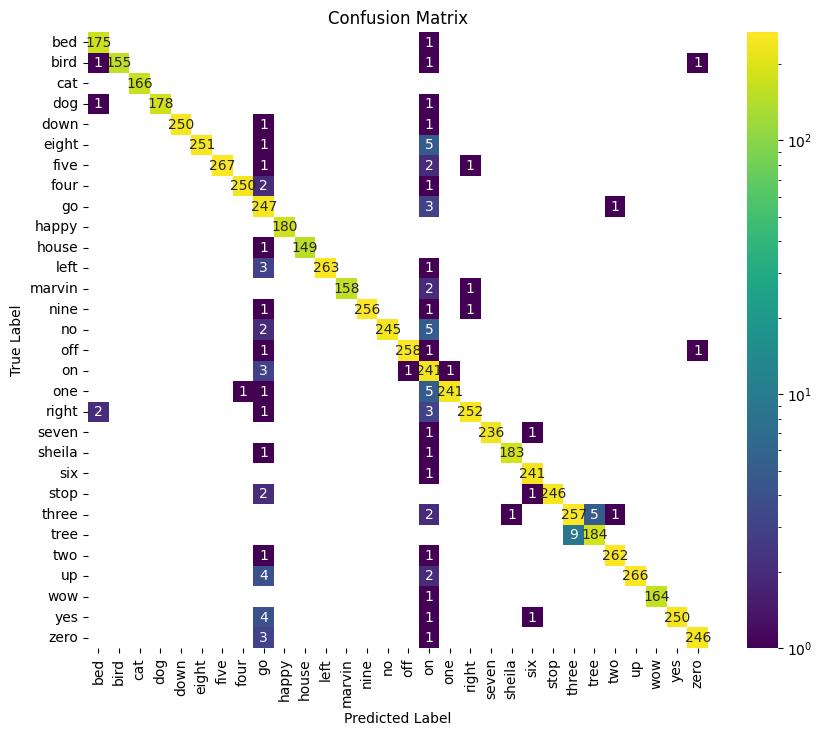

In [6]:
df = pd.read_csv('./data/train/results/confusion_matrix_a1.csv', index_col=0)
show_confusion_matrix(df)

## Prediction on competition dataset

In [23]:
model_silence_detection = Wav2Vec2ForCTC.from_pretrained("models/model_silence_detection")
model_speech_classification = Wav2Vec2ForCTC.from_pretrained("models/model_lr_0.0001")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
audio_dir = "./data/test/audio/"

predict_for_competition_approach_1(model_silence_detection, model_speech_classification, processor, audio_dir)

# Second approach: classification with silence as class
## Datasets
### Create & save datasets

In [2]:
create_approach_2_lists()

In [2]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
audio_dir = "data/train/audio/"
dataset_test_a2 = create_dataset(audio_dir, processor, 'approach_2_lists/testing_list_approach_2', silence_included=True)
dataset_test_a2.save_to_disk('./datasets/dataset_test_a2')
dataset_train_a2 = create_dataset(audio_dir, processor, 'approach_2_lists/training_list_approach_2', silence_included=True)
dataset_train_a2.save_to_disk('./datasets/dataset_train_a2')
dataset_valid_a2 = create_dataset(audio_dir, processor, 'approach_2_lists/validation_list_approach_2', silence_included=True)
dataset_valid_a2.save_to_disk('./datasets/dataset_valid_a2')

c:\Users\bagin\PycharmProjects\DL\2024Z_DeepLearning\.venv\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


### Load datasets

In [2]:
dataset_train_a2 = Dataset.load_from_disk("./datasets/dataset_train_a2")
dataset_valid_a2 = Dataset.load_from_disk("./datasets/dataset_valid_a2")
dataset_test_a2 = Dataset.load_from_disk("./datasets/dataset_test_a2")

## Classification model

In [3]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.freeze_feature_extractor()
model.to('cuda')

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
training_args = TrainingArguments(
    output_dir="./output_dir",
    per_device_train_batch_size=16,
    num_train_epochs=10,
    logging_dir="./logs",
    save_strategy='epoch', 
    evaluation_strategy='epoch',
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    labels = [list(item[0]) for item in labels]
    if all(isinstance(i, list) for i in preds):
        preds = [item for sublist in preds for item in sublist]
    pred_transcriptions = processor.batch_decode(preds)
    true_transcriptions = processor.batch_decode(labels)
    cer_score = calculate_cer_for_list(true_transcriptions, pred_transcriptions)

    correct_predictions = sum([true == pred for true, pred in zip(true_transcriptions, pred_transcriptions)])
    total_predictions = len(true_transcriptions)
    accuracy = correct_predictions / total_predictions

    available_labels = get_available_labels('data/train/audio/') + ['']
    cer_score_closest, accuracy_closest = compute_metrics_with_closest_label(available_labels, pred_transcriptions, true_transcriptions)
    return {"accuracy": accuracy, "cer": cer_score, "accuracy_closest": accuracy_closest, "cer_closest": cer_score_closest}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train_a2,
    eval_dataset=dataset_valid_a2,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[SaveMetricsCallback(dataset_valid_a2, 'approach_2')],
)

trainer.train()
trainer.save_model(f"models/model_approach2")

  1%|          | 500/41770 [01:51<2:29:37,  4.60it/s]

{'loss': -96.0794, 'grad_norm': 736.5828857421875, 'learning_rate': 4.9401484318889156e-05, 'epoch': 0.12}


  2%|▏         | 1000/41770 [03:41<2:30:07,  4.53it/s]

{'loss': -122.8619, 'grad_norm': 1695.8096923828125, 'learning_rate': 4.8802968637778315e-05, 'epoch': 0.24}


  4%|▎         | 1500/41770 [05:31<2:27:03,  4.56it/s]

{'loss': -135.1103, 'grad_norm': 600.9548950195312, 'learning_rate': 4.820445295666747e-05, 'epoch': 0.36}


  5%|▍         | 2001/41770 [07:21<2:25:19,  4.56it/s]

{'loss': -134.869, 'grad_norm': 1138.597412109375, 'learning_rate': 4.760593727555662e-05, 'epoch': 0.48}


  6%|▌         | 2501/41770 [09:11<2:20:35,  4.66it/s]

{'loss': -141.0247, 'grad_norm': 594.8341674804688, 'learning_rate': 4.7007421594445775e-05, 'epoch': 0.6}


  7%|▋         | 3000/41770 [11:01<2:22:34,  4.53it/s]

{'loss': -143.5327, 'grad_norm': 606.1616821289062, 'learning_rate': 4.6408905913334935e-05, 'epoch': 0.72}


  8%|▊         | 3500/41770 [12:52<2:22:34,  4.47it/s]

{'loss': -145.37, 'grad_norm': 1455.4814453125, 'learning_rate': 4.581039023222409e-05, 'epoch': 0.84}


 10%|▉         | 4001/41770 [14:43<2:19:22,  4.52it/s]

{'loss': -147.3783, 'grad_norm': 323.022216796875, 'learning_rate': 4.521187455111324e-05, 'epoch': 0.96}


                                                      
 10%|█         | 4177/41770 [16:55<2:08:14,  4.89it/s]

{'eval_loss': -83.5517807006836, 'eval_accuracy': 0.8350092054949724, 'eval_cer': 0.09409904168437028, 'eval_accuracy_closest': 0.8433649624699051, 'eval_cer_closest': 0.0, 'eval_runtime': 93.968, 'eval_samples_per_second': 75.143, 'eval_steps_per_second': 9.397, 'epoch': 1.0}


 11%|█         | 4500/41770 [18:08<2:15:53,  4.57it/s]  

{'loss': -152.3696, 'grad_norm': 1857.0087890625, 'learning_rate': 4.4613358870002394e-05, 'epoch': 1.08}


 12%|█▏        | 5000/41770 [19:58<2:15:02,  4.54it/s]

{'loss': -151.8733, 'grad_norm': 4640.080078125, 'learning_rate': 4.4014843188891554e-05, 'epoch': 1.2}


 13%|█▎        | 5500/41770 [21:49<2:12:27,  4.56it/s]

{'loss': -154.2466, 'grad_norm': 665.2847290039062, 'learning_rate': 4.341632750778071e-05, 'epoch': 1.32}


 14%|█▍        | 6000/41770 [23:37<2:11:00,  4.55it/s]

{'loss': -157.4885, 'grad_norm': 568.8114624023438, 'learning_rate': 4.281781182666986e-05, 'epoch': 1.44}


 16%|█▌        | 6501/41770 [25:26<2:06:00,  4.66it/s]

{'loss': -159.9443, 'grad_norm': 985.9043579101562, 'learning_rate': 4.221929614555902e-05, 'epoch': 1.56}


 17%|█▋        | 7000/41770 [27:13<2:07:55,  4.53it/s]

{'loss': -157.3439, 'grad_norm': 1573.4356689453125, 'learning_rate': 4.1620780464448174e-05, 'epoch': 1.68}


 18%|█▊        | 7501/41770 [29:02<2:03:50,  4.61it/s]

{'loss': -160.9668, 'grad_norm': 4537.8505859375, 'learning_rate': 4.102226478333733e-05, 'epoch': 1.8}


 19%|█▉        | 8000/41770 [30:50<2:04:08,  4.53it/s]

{'loss': -163.7705, 'grad_norm': 2329.993408203125, 'learning_rate': 4.042374910222648e-05, 'epoch': 1.92}


                                                      
 20%|██        | 8354/41770 [33:41<1:48:32,  5.13it/s]

{'eval_loss': -92.37083435058594, 'eval_accuracy': 0.7946466506160601, 'eval_cer': 0.11396402775810884, 'eval_accuracy_closest': 0.8401076334796771, 'eval_cer_closest': 0.0, 'eval_runtime': 94.0004, 'eval_samples_per_second': 75.117, 'eval_steps_per_second': 9.394, 'epoch': 2.0}


 20%|██        | 8500/41770 [34:14<2:00:22,  4.61it/s]  

{'loss': -163.3982, 'grad_norm': 683.1800537109375, 'learning_rate': 3.982523342111564e-05, 'epoch': 2.03}


 22%|██▏       | 9000/41770 [36:03<1:59:57,  4.55it/s]

{'loss': -165.8953, 'grad_norm': 751.6768188476562, 'learning_rate': 3.922671774000479e-05, 'epoch': 2.15}


 23%|██▎       | 9501/41770 [37:52<1:53:22,  4.74it/s]

{'loss': -168.265, 'grad_norm': 758.88427734375, 'learning_rate': 3.8628202058893946e-05, 'epoch': 2.27}


 24%|██▍       | 10000/41770 [39:40<1:53:06,  4.68it/s]

{'loss': -169.3196, 'grad_norm': 1338.9437255859375, 'learning_rate': 3.80296863777831e-05, 'epoch': 2.39}


 25%|██▌       | 10501/41770 [41:29<1:52:31,  4.63it/s]

{'loss': -170.576, 'grad_norm': 5148.59326171875, 'learning_rate': 3.743117069667225e-05, 'epoch': 2.51}


 26%|██▋       | 11000/41770 [43:18<1:48:34,  4.72it/s]

{'loss': -170.7133, 'grad_norm': 633.9995727539062, 'learning_rate': 3.6832655015561406e-05, 'epoch': 2.63}


 28%|██▊       | 11500/41770 [45:07<1:48:38,  4.64it/s]

{'loss': -172.376, 'grad_norm': 1056.753662109375, 'learning_rate': 3.623413933445056e-05, 'epoch': 2.75}


 29%|██▊       | 12000/41770 [46:56<1:45:36,  4.70it/s]

{'loss': -172.1075, 'grad_norm': 777.9732666015625, 'learning_rate': 3.563562365333972e-05, 'epoch': 2.87}


 30%|██▉       | 12500/41770 [48:45<1:43:10,  4.73it/s]

{'loss': -169.6017, 'grad_norm': 824.0993041992188, 'learning_rate': 3.503710797222887e-05, 'epoch': 2.99}


                                                       
 30%|███       | 12531/41770 [50:25<1:39:01,  4.92it/s]

{'eval_loss': -92.77324676513672, 'eval_accuracy': 0.810791672567625, 'eval_cer': 0.10154133031204289, 'eval_accuracy_closest': 0.8466222914601331, 'eval_cer_closest': 0.0, 'eval_runtime': 94.105, 'eval_samples_per_second': 75.033, 'eval_steps_per_second': 9.383, 'epoch': 3.0}


 31%|███       | 13000/41770 [52:09<1:46:40,  4.49it/s]  

{'loss': -174.5498, 'grad_norm': 598.4769287109375, 'learning_rate': 3.4438592291118025e-05, 'epoch': 3.11}


 32%|███▏      | 13500/41770 [53:58<1:44:10,  4.52it/s]

{'loss': -175.8549, 'grad_norm': 1586.34716796875, 'learning_rate': 3.3840076610007185e-05, 'epoch': 3.23}


 34%|███▎      | 14000/41770 [55:47<1:38:59,  4.68it/s]

{'loss': -174.3317, 'grad_norm': 752.0604858398438, 'learning_rate': 3.324156092889634e-05, 'epoch': 3.35}


 35%|███▍      | 14501/41770 [57:35<1:33:56,  4.84it/s]

{'loss': -177.4575, 'grad_norm': 424.7781066894531, 'learning_rate': 3.264304524778549e-05, 'epoch': 3.47}


 36%|███▌      | 15000/41770 [59:24<1:38:42,  4.52it/s]

{'loss': -177.1526, 'grad_norm': 275.3307189941406, 'learning_rate': 3.2044529566674644e-05, 'epoch': 3.59}


 37%|███▋      | 15500/41770 [1:01:13<1:33:19,  4.69it/s]

{'loss': -175.8385, 'grad_norm': 165.71958923339844, 'learning_rate': 3.1446013885563804e-05, 'epoch': 3.71}


 38%|███▊      | 16000/41770 [1:03:02<1:34:22,  4.55it/s]

{'loss': -178.4416, 'grad_norm': 303.0020446777344, 'learning_rate': 3.084749820445296e-05, 'epoch': 3.83}


 40%|███▉      | 16500/41770 [1:04:51<1:32:35,  4.55it/s]

{'loss': -178.2211, 'grad_norm': 1942.10888671875, 'learning_rate': 3.024898252334211e-05, 'epoch': 3.95}


                                                         
 40%|████      | 16708/41770 [1:07:11<1:24:13,  4.96it/s]

{'eval_loss': -91.8363037109375, 'eval_accuracy': 0.8199971675400085, 'eval_cer': 0.08769768210357368, 'eval_accuracy_closest': 0.847613652457159, 'eval_cer_closest': 0.0, 'eval_runtime': 94.795, 'eval_samples_per_second': 74.487, 'eval_steps_per_second': 9.315, 'epoch': 4.0}


 41%|████      | 17001/41770 [1:08:16<1:30:13,  4.58it/s]  

{'loss': -179.3, 'grad_norm': 296.00775146484375, 'learning_rate': 2.9650466842231267e-05, 'epoch': 4.07}


 42%|████▏     | 17500/41770 [1:10:05<1:28:46,  4.56it/s]

{'loss': -180.2244, 'grad_norm': 900.99462890625, 'learning_rate': 2.9051951161120424e-05, 'epoch': 4.19}


 43%|████▎     | 18000/41770 [1:11:54<1:26:50,  4.56it/s]

{'loss': -179.8913, 'grad_norm': 341.8797302246094, 'learning_rate': 2.8453435480009577e-05, 'epoch': 4.31}


 44%|████▍     | 18500/41770 [1:13:43<1:26:40,  4.47it/s]

{'loss': -181.3423, 'grad_norm': 471.5987243652344, 'learning_rate': 2.7854919798898733e-05, 'epoch': 4.43}


 45%|████▌     | 19000/41770 [1:15:32<1:20:59,  4.69it/s]

{'loss': -182.8455, 'grad_norm': 29.069231033325195, 'learning_rate': 2.7256404117787886e-05, 'epoch': 4.55}


 47%|████▋     | 19501/41770 [1:17:22<1:20:21,  4.62it/s]

{'loss': -182.3274, 'grad_norm': 851.5576171875, 'learning_rate': 2.6657888436677043e-05, 'epoch': 4.67}


 48%|████▊     | 20000/41770 [1:19:11<1:20:04,  4.53it/s]

{'loss': -183.3268, 'grad_norm': 483.12841796875, 'learning_rate': 2.6059372755566196e-05, 'epoch': 4.79}


 49%|████▉     | 20501/41770 [1:21:01<1:18:37,  4.51it/s]

{'loss': -180.1752, 'grad_norm': 1240.16943359375, 'learning_rate': 2.5460857074455353e-05, 'epoch': 4.91}


                                                         
 50%|█████     | 20885/41770 [1:24:00<1:10:04,  4.97it/s]

{'eval_loss': -93.18434143066406, 'eval_accuracy': 0.8436482084690554, 'eval_cer': 0.07530330925742303, 'eval_accuracy_closest': 0.8554029174337913, 'eval_cer_closest': 0.0, 'eval_runtime': 95.3151, 'eval_samples_per_second': 74.081, 'eval_steps_per_second': 9.264, 'epoch': 5.0}


 50%|█████     | 21000/41770 [1:24:26<1:13:12,  4.73it/s]  

{'loss': -179.9179, 'grad_norm': 12436.134765625, 'learning_rate': 2.4862341393344506e-05, 'epoch': 5.03}


 51%|█████▏    | 21500/41770 [1:26:15<1:13:55,  4.57it/s]

{'loss': -184.2728, 'grad_norm': 790.9099731445312, 'learning_rate': 2.4263825712233662e-05, 'epoch': 5.15}


 53%|█████▎    | 22000/41770 [1:28:04<1:11:54,  4.58it/s]

{'loss': -183.278, 'grad_norm': 694.736572265625, 'learning_rate': 2.3665310031122815e-05, 'epoch': 5.27}


 54%|█████▍    | 22501/41770 [1:29:53<1:10:15,  4.57it/s]

{'loss': -183.4406, 'grad_norm': 221.79823303222656, 'learning_rate': 2.3066794350011972e-05, 'epoch': 5.39}


 55%|█████▌    | 23000/41770 [1:31:42<1:08:50,  4.54it/s]

{'loss': -182.9045, 'grad_norm': 278.67742919921875, 'learning_rate': 2.246827866890113e-05, 'epoch': 5.51}


 56%|█████▋    | 23500/41770 [1:33:31<1:05:25,  4.65it/s]

{'loss': -185.2195, 'grad_norm': 868.71826171875, 'learning_rate': 2.186976298779028e-05, 'epoch': 5.63}


 57%|█████▋    | 24000/41770 [1:35:21<1:05:00,  4.56it/s]

{'loss': -185.6024, 'grad_norm': 2285.539794921875, 'learning_rate': 2.1271247306679438e-05, 'epoch': 5.75}


 59%|█████▊    | 24500/41770 [1:37:10<1:04:12,  4.48it/s]

{'loss': -187.2449, 'grad_norm': 96.82779693603516, 'learning_rate': 2.067273162556859e-05, 'epoch': 5.87}


 60%|█████▉    | 25000/41770 [1:38:59<1:02:07,  4.50it/s]

{'loss': -187.579, 'grad_norm': 1006.1207275390625, 'learning_rate': 2.0074215944457748e-05, 'epoch': 5.99}


                                                         
 60%|██████    | 25062/41770 [1:40:49<54:15,  5.13it/s]

{'eval_loss': -100.92212677001953, 'eval_accuracy': 0.8437898314686305, 'eval_cer': 0.07289807864797203, 'eval_accuracy_closest': 0.855119671434641, 'eval_cer_closest': 0.0, 'eval_runtime': 96.047, 'eval_samples_per_second': 73.516, 'eval_steps_per_second': 9.193, 'epoch': 6.0}


 61%|██████    | 25500/41770 [1:42:25<1:00:59,  4.45it/s]  

{'loss': -187.2527, 'grad_norm': 642.361328125, 'learning_rate': 1.94757002633469e-05, 'epoch': 6.1}


 62%|██████▏   | 26000/41770 [1:44:15<58:07,  4.52it/s]  

{'loss': -188.6118, 'grad_norm': 661.3380737304688, 'learning_rate': 1.8877184582236054e-05, 'epoch': 6.22}


 63%|██████▎   | 26500/41770 [1:46:04<54:56,  4.63it/s]  

{'loss': -190.5381, 'grad_norm': 994.843505859375, 'learning_rate': 1.827866890112521e-05, 'epoch': 6.34}


 65%|██████▍   | 27000/41770 [1:47:54<53:26,  4.61it/s]

{'loss': -191.1612, 'grad_norm': 991.2366333007812, 'learning_rate': 1.7680153220014364e-05, 'epoch': 6.46}


 66%|██████▌   | 27501/41770 [1:49:43<51:38,  4.61it/s]

{'loss': -192.252, 'grad_norm': 570.5217895507812, 'learning_rate': 1.708163753890352e-05, 'epoch': 6.58}


 67%|██████▋   | 28000/41770 [1:51:32<53:40,  4.28it/s]

{'loss': -189.1305, 'grad_norm': 250.27333068847656, 'learning_rate': 1.6483121857792674e-05, 'epoch': 6.7}


 68%|██████▊   | 28500/41770 [1:53:24<49:26,  4.47it/s]

{'loss': -190.973, 'grad_norm': 856.3637084960938, 'learning_rate': 1.588460617668183e-05, 'epoch': 6.82}


 69%|██████▉   | 29000/41770 [1:55:15<47:11,  4.51it/s]

{'loss': -192.5498, 'grad_norm': 459.7550354003906, 'learning_rate': 1.5286090495570983e-05, 'epoch': 6.94}


                                                       
 70%|███████   | 29239/41770 [1:57:43<41:50,  4.99it/s]

{'eval_loss': -103.28590393066406, 'eval_accuracy': 0.8525704574422887, 'eval_cer': 0.06229287636312098, 'eval_accuracy_closest': 0.8610678374167965, 'eval_cer_closest': 0.0, 'eval_runtime': 95.368, 'eval_samples_per_second': 74.04, 'eval_steps_per_second': 9.259, 'epoch': 7.0}


 71%|███████   | 29500/41770 [1:58:41<43:30,  4.70it/s]   

{'loss': -190.3978, 'grad_norm': 2434.53759765625, 'learning_rate': 1.468757481446014e-05, 'epoch': 7.06}


 72%|███████▏  | 30000/41770 [2:00:30<41:25,  4.73it/s]

{'loss': -192.5903, 'grad_norm': 845.6234130859375, 'learning_rate': 1.4089059133349295e-05, 'epoch': 7.18}


 73%|███████▎  | 30500/41770 [2:02:18<41:30,  4.53it/s]

{'loss': -193.7856, 'grad_norm': 60.47301483154297, 'learning_rate': 1.349054345223845e-05, 'epoch': 7.3}


 74%|███████▍  | 31000/41770 [2:04:07<38:20,  4.68it/s]

{'loss': -190.947, 'grad_norm': 1769.9560546875, 'learning_rate': 1.2892027771127604e-05, 'epoch': 7.42}


 75%|███████▌  | 31500/41770 [2:05:56<36:22,  4.70it/s]

{'loss': -191.89, 'grad_norm': 1011.6132202148438, 'learning_rate': 1.2293512090016759e-05, 'epoch': 7.54}


 77%|███████▋  | 32001/41770 [2:07:44<35:33,  4.58it/s]

{'loss': -194.7459, 'grad_norm': 760.0263671875, 'learning_rate': 1.1694996408905914e-05, 'epoch': 7.66}


 78%|███████▊  | 32500/41770 [2:09:33<33:57,  4.55it/s]

{'loss': -193.9314, 'grad_norm': 1131.6256103515625, 'learning_rate': 1.1096480727795069e-05, 'epoch': 7.78}


 79%|███████▉  | 33000/41770 [2:11:22<31:40,  4.61it/s]

{'loss': -193.2834, 'grad_norm': 310.17669677734375, 'learning_rate': 1.0497965046684224e-05, 'epoch': 7.9}


                                                       
 80%|████████  | 33416/41770 [2:14:28<27:37,  5.04it/s]

{'eval_loss': -103.78255462646484, 'eval_accuracy': 0.8607845914176462, 'eval_cer': 0.05899070008969418, 'eval_accuracy_closest': 0.8627673134116981, 'eval_cer_closest': 0.0, 'eval_runtime': 95.678, 'eval_samples_per_second': 73.8, 'eval_steps_per_second': 9.229, 'epoch': 8.0}


 80%|████████  | 33500/41770 [2:14:47<29:45,  4.63it/s]   

{'loss': -194.2526, 'grad_norm': 668.9730834960938, 'learning_rate': 9.899449365573378e-06, 'epoch': 8.02}


 81%|████████▏ | 34001/41770 [2:16:37<27:43,  4.67it/s]

{'loss': -192.9224, 'grad_norm': 622.7406616210938, 'learning_rate': 9.300933684462533e-06, 'epoch': 8.14}


 83%|████████▎ | 34500/41770 [2:18:26<26:49,  4.52it/s]

{'loss': -194.4458, 'grad_norm': 969.4942016601562, 'learning_rate': 8.702418003351688e-06, 'epoch': 8.26}


 84%|████████▍ | 35000/41770 [2:20:15<24:48,  4.55it/s]

{'loss': -197.0723, 'grad_norm': 625.75, 'learning_rate': 8.103902322240843e-06, 'epoch': 8.38}


 85%|████████▍ | 35501/41770 [2:22:05<22:31,  4.64it/s]

{'loss': -195.1304, 'grad_norm': 267.9421081542969, 'learning_rate': 7.505386641129998e-06, 'epoch': 8.5}


 86%|████████▌ | 36000/41770 [2:23:54<21:31,  4.47it/s]

{'loss': -193.1979, 'grad_norm': 233.2543487548828, 'learning_rate': 6.906870960019153e-06, 'epoch': 8.62}


 87%|████████▋ | 36500/41770 [2:25:43<19:00,  4.62it/s]

{'loss': -195.4495, 'grad_norm': 23.289344787597656, 'learning_rate': 6.308355278908308e-06, 'epoch': 8.74}


 89%|████████▊ | 37000/41770 [2:27:32<17:06,  4.65it/s]

{'loss': -196.6844, 'grad_norm': 280.7275390625, 'learning_rate': 5.709839597797462e-06, 'epoch': 8.86}


 90%|████████▉ | 37500/41770 [2:29:22<15:25,  4.61it/s]

{'loss': -197.1475, 'grad_norm': 275.4624328613281, 'learning_rate': 5.111323916686617e-06, 'epoch': 8.98}


                                                       
 90%|█████████ | 37593/41770 [2:31:17<13:32,  5.14it/s]

{'eval_loss': -99.87155151367188, 'eval_accuracy': 0.8493131284520606, 'eval_cer': 0.058681489873955016, 'eval_accuracy_closest': 0.8617759524146722, 'eval_cer_closest': 0.0, 'eval_runtime': 95.492, 'eval_samples_per_second': 73.943, 'eval_steps_per_second': 9.247, 'epoch': 9.0}


 91%|█████████ | 38000/41770 [2:32:47<14:12,  4.42it/s]   

{'loss': -195.0936, 'grad_norm': 382.1725769042969, 'learning_rate': 4.512808235575772e-06, 'epoch': 9.1}


 92%|█████████▏| 38500/41770 [2:34:36<12:06,  4.50it/s]

{'loss': -193.975, 'grad_norm': 16.483932495117188, 'learning_rate': 3.914292554464928e-06, 'epoch': 9.22}


 93%|█████████▎| 39000/41770 [2:36:25<10:15,  4.50it/s]

{'loss': -196.3464, 'grad_norm': 76.26219940185547, 'learning_rate': 3.3157768733540817e-06, 'epoch': 9.34}


 95%|█████████▍| 39500/41770 [2:38:15<08:13,  4.60it/s]

{'loss': -196.8722, 'grad_norm': 234.08786010742188, 'learning_rate': 2.717261192243237e-06, 'epoch': 9.46}


 96%|█████████▌| 40000/41770 [2:40:04<06:24,  4.61it/s]

{'loss': -196.1953, 'grad_norm': 63.09201431274414, 'learning_rate': 2.118745511132392e-06, 'epoch': 9.58}


 97%|█████████▋| 40501/41770 [2:41:54<04:31,  4.67it/s]

{'loss': -196.7581, 'grad_norm': 674.3788452148438, 'learning_rate': 1.5202298300215465e-06, 'epoch': 9.7}


 98%|█████████▊| 41001/41770 [2:43:44<02:49,  4.54it/s]

{'loss': -195.3435, 'grad_norm': 11.107024192810059, 'learning_rate': 9.217141489107015e-07, 'epoch': 9.82}


 99%|█████████▉| 41500/41770 [2:45:34<01:00,  4.46it/s]

{'loss': -195.7869, 'grad_norm': 542.8697509765625, 'learning_rate': 3.2319846779985637e-07, 'epoch': 9.94}


                                                       
100%|██████████| 41770/41770 [2:48:09<00:00,  4.97it/s]

{'eval_loss': -103.06314849853516, 'eval_accuracy': 0.8634754284095737, 'eval_cer': 0.056165321248170315, 'eval_accuracy_closest': 0.8651749044044753, 'eval_cer_closest': 0.0, 'eval_runtime': 96.36, 'eval_samples_per_second': 73.277, 'eval_steps_per_second': 9.164, 'epoch': 10.0}


100%|██████████| 41770/41770 [2:48:10<00:00,  4.14it/s]


{'train_runtime': 10090.6199, 'train_samples_per_second': 66.223, 'train_steps_per_second': 4.139, 'train_loss': -177.8688777456907, 'epoch': 10.0}


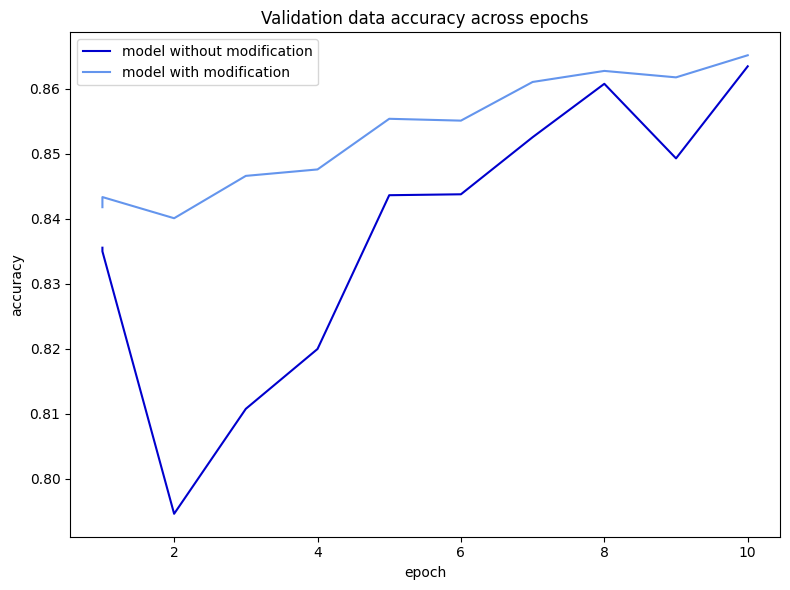

In [2]:
vis_accuracy_cer_one_file("data_for_vis/validation_metrics_approach_2.csv")

### Prediction on test data

In [21]:
model_speech_classification = Wav2Vec2ForCTC.from_pretrained("models/model_approach2")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
audio_dir = "./data/train/audio/"
available_labels = get_available_labels("./data/train/audio/")

with open("./data/train/approach_2_lists/testing_list_approach_2.txt", "r") as file:
    testing_speech_files = [line.strip() for line in file]
    
correct_silence_predictions = 0
total_cer = 0
total_cer_org = 0
correct_speech_predictions = 0
correct_speech_predictions_org = 0

true_labels = []
predicted_labels = []

with open('./data/train/results/testing_classification_a2.txt', 'w') as f:
    for audio_file in testing_speech_files:
        audio, rate = librosa.load(os.path.join(audio_dir, audio_file), sr=16000)
        inputs = processor(audio, return_tensors="pt", padding=True, sampling_rate=16000)
        with torch.no_grad():
            logits = model_speech_classification(inputs.input_values).logits

        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.decode(predicted_ids[0])

        true_label = audio_file.split('/')[0]
        closest_label = min(available_labels, key=lambda l: Levenshtein.distance(l, transcription)).lower()
        
        true_labels.append(true_label)
        predicted_labels.append(closest_label)
        
        if closest_label == true_label:
            correct_speech_predictions += 1
        total_cer += cer(true_label, closest_label)
        if transcription.lower() == true_label:
            correct_speech_predictions_org += 1
        total_cer_org += cer(true_label, transcription.lower())
        f.write(f'{audio_file},{closest_label}\n')

available_labels_lower = [label.lower() for label in available_labels]
conf_mat = confusion_matrix(true_labels, predicted_labels, labels=available_labels_lower)
df = pd.DataFrame(conf_mat, index=available_labels_lower, columns=available_labels_lower)
df.to_csv('./data/train/results/confusion_matrix_a2.csv')
        
accuracy_speech = correct_speech_predictions / len(testing_speech_files)
my_cer = total_cer / len(testing_speech_files)
print(f'Accuracy of speech classification: {accuracy_speech * 100}%')
print(f'CER of speech classification: {my_cer * 100}%')
print(f'Accuracy of speech classification org: {correct_speech_predictions_org / len(testing_speech_files) * 100}%')
print(f'CER of speech classification org : {total_cer_org / len(testing_speech_files) * 100}%')

Accuracy of speech classification: 94.16737109044801%
CER of speech classification: 5.3519770827463145%
Accuracy of speech classification org: 92.32178078331924%
CER of speech classification org : 5.711937635014561%


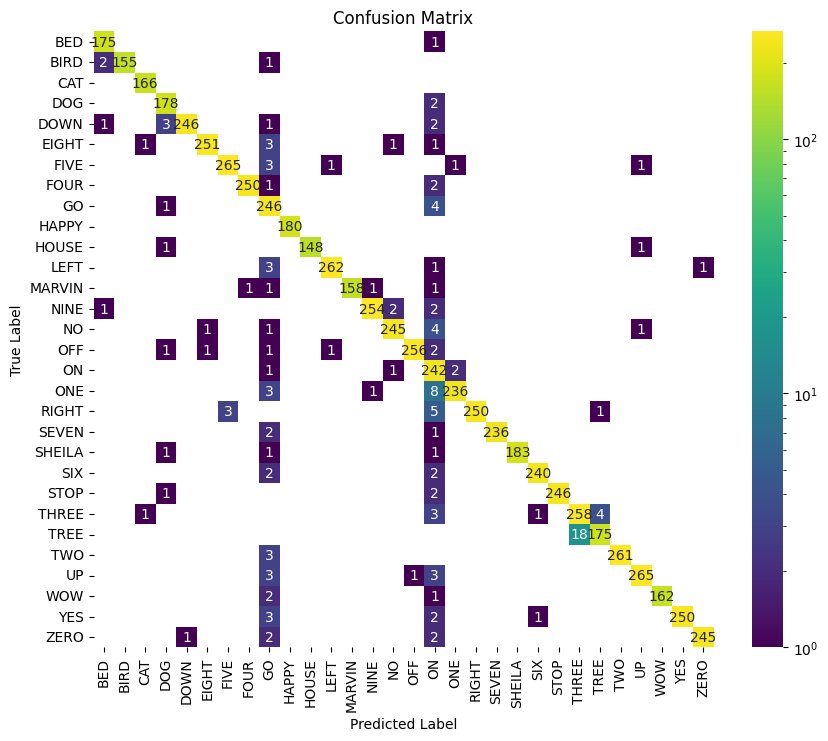

In [22]:
df = pd.read_csv('./data/train/results/confusion_matrix_a2.csv', index_col=0)
show_confusion_matrix(df)

## Prediction on competition dataset

In [12]:
model_speech_classification = Wav2Vec2ForCTC.from_pretrained("models/model_approach2")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
audio_dir = "./data/test/audio/"

available_labels = get_available_labels('./data/train/audio/') + [""]
labels_to_classify = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
with open('./data/test/prediction_approach_2.csv', 'w') as f:
    f.write(f'fname,label\n')
    for audio_file in os.listdir("./data/test/audio"):
        audio, rate = librosa.load(os.path.join(audio_dir, audio_file), sr=16000)
        inputs = processor(audio, return_tensors="pt", padding=True, sampling_rate=16000)
        with torch.no_grad():
            logits = model_speech_classification(inputs.input_values).logits

        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.decode(predicted_ids[0])
        closest_label = min(available_labels, key=lambda l: Levenshtein.distance(l, transcription)).lower()
        if closest_label in labels_to_classify:
            f.write(f'{audio_file},{closest_label}\n')
        elif closest_label == '':
            f.write(f'{audio_file},silence\n')
        else:
            f.write(f'{audio_file},unknown\n')